<a href="https://colab.research.google.com/github/yuvalira/Final-Project-Adversarial-Attack-on-Tabular-Classification/blob/main/ATTACK/GBT_Attack.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [100]:
# System and file handling
import os
import pickle
import joblib

# Data processing and manipulation
import numpy as np
import pandas as pd
from random import sample
from scipy.stats import pointbiserialr
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

# Evaluation metrics
from sklearn.metrics import (
    accuracy_score,
    precision_score,
    recall_score,
    f1_score,
    roc_curve,
    roc_auc_score
)

# Transformers and model loading
import torch
from transformers import RobertaTokenizer, RobertaForMaskedLM
from huggingface_hub import hf_hub_download

# Visualization
import matplotlib.pyplot as plt
from matplotlib.patches import FancyArrowPatch
import matplotlib.patheffects as pe
from matplotlib.lines import Line2D

# **1. Model and Dataset Setup**

### 1.1 Load pretrained GBT model and label encoders from GitHub repository


In [117]:
# Git clone
REPO_URL = "https://github.com/yuvalira/Final-Project-Adversarial-Attack-on-Tabular-Classification.git"
!git clone {REPO_URL}
%cd Final-Project-Adversarial-Attack-on-Tabular-Classification

# Read GBT model (sklearn)
model_path = 'GBT/sklearn_GBT_model.joblib'
assert os.path.exists(model_path), f"Model file not found at {model_path}"
model_gbt = joblib.load(model_path)
print("sklearn GBT model loaded successfully.")

# Load label encoders for decoding categorical features
with open('data/label_encoders.pkl', 'rb') as f:
    encoders = pickle.load(f)
print("Label encoders loaded successfully.")

Cloning into 'Final-Project-Adversarial-Attack-on-Tabular-Classification'...
remote: Enumerating objects: 286, done.
remote: Counting objects: 100% (118/118), done.
remote: Compressing objects: 100% (105/105), done.
remote: Total 286 (delta 61), reused 13 (delta 13), pack-reused 168 (from 1)
Receiving objects: 100% (286/286), 6.31 MiB | 8.49 MiB/s, done.
Resolving deltas: 100% (120/120), done.
/content/Final-Project-Adversarial-Attack-on-Tabular-Classification/Final-Project-Adversarial-Attack-on-Tabular-Classification/Final-Project-Adversarial-Attack-on-Tabular-Classification
sklearn GBT model loaded successfully.
Label encoders loaded successfully.


### 1.2 Load attack input dataset from Hugging Face Hub
Download the experiment_data.csv file, which serves as the input for adversarial attacks

In [11]:
repo_id = "ETdanR/RoBERTa_FT_adult" # This is the same repo where your model is


csv_filename = "experiment_data.csv"
csv_path = hf_hub_download(repo_id=repo_id, filename=csv_filename)
experiment_data = pd.read_csv(csv_path)

### 1.3 Load fine-tuned RoBERTa model and tokenizer for masked income prediction


In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Load fine-tuned model directly from Hugging Face Hub
model_path = "ETdanR/RoBERTa_FT_adult"
tokenizer = RobertaTokenizer.from_pretrained(model_path)
model = RobertaForMaskedLM.from_pretrained(model_path)
model.eval()
model.to(device)

# Define mask token info
mask_token = tokenizer.mask_token
mask_token_id = tokenizer.mask_token_id

# Token IDs for income prediction (example IDs from your snippet)
greater_than_id = 9312  # "Greater"
less_than_id = 10862    # "Less"

Using device: cuda


# **2. Prediction Functions**

### 2.1 predict_GBT
Predicts class labels using a trained GBT model.
Automatically applies label encoding to categorical string features if needed.

In [118]:
def predict_GBT(input_df: pd.DataFrame) -> tuple[np.ndarray, np.ndarray]:
    """
    Makes predictions using the loaded GBT model, handling label encoding for
    categorical features.
    Args: input_df (pd.DataFrame): DataFrame containing the features for prediction.
                                 Can contain string categorical values.
    Returns: Tuple: Predicted class labels (0 or 1), Confidence scores (probability of class 1, i.e., > 50K)
    """
    # Create a copy of the input to avoid modifying the original DataFrame
    processed_df = input_df.copy()

    # Apply label encoding to each categorical feature using the saved encoders
    for feature in categorical_features:
        if feature in processed_df.columns and feature in encoders:
            le = encoders[feature]
            try:
                # Transform known categories
                processed_df[feature] = le.transform(processed_df[feature])
            except ValueError as e:
                # Handle unseen categories by mapping them to 0 (first known class)
                print(f"Warning: Could not transform feature '{feature}' due to unknown category. Error: {e}")

                unknown_cats = processed_df[feature][~processed_df[feature].isin(le.classes_)]
                if not unknown_cats.empty:
                    print(f"Mapping unknown categories {unknown_cats.unique().tolist()} in '{feature}' to 0 (first class).")
                    processed_df[feature] = processed_df[feature].apply(
                        lambda x: le.transform([x])[0] if x in le.classes_ else 0
                    )

    # Get predicted class labels
    predictions = model_gbt.predict(processed_df)

    # Get probabilities of class 1 (i.e., > 50K)
    probabilities = model_gbt.predict_proba(processed_df)[:, 1]

    return predictions, probabilities

### 2.2 Predict LLM
Generate predictions using the fine-tuned RoBERTa language model.
Converts each input row into a pseudo-sentence with a masked income token, performs batched inference, and maps predicted tokens to class labels.


In [119]:
def predict_LM(df: pd.DataFrame):
    """
    Generates predictions for a DataFrame of input features using a Language Model.
    Args: df (pd.DataFrame): DataFrame with tabular features per row.
    Returns: np.ndarray: Array of predictions (0 for <=50K, 1 for >50K, -1 for unknown).
    """

    # Check if model and tokenizer are loaded
    if tokenizer is None or model is None:
        print("Error: Hugging Face tokenizer or model not loaded. Returning random predictions.")
        random_preds = np.random.randint(0, 2, size=len(df))
        random_scores = np.random.rand(len(df))
        return random_preds, random_scores

    # Convert each row into a pseudo-sentence with a masked income token
    sentences = []
    for _, row in df.iterrows():
        sentence_parts = [
            f"age: {row['age']}",
            f"workclass: {row['workclass']}",
            f"education: {row['education']}",
            f"educational-num: {row['educational-num']}",
            f"marital-status: {row['marital-status']}",
            f"occupation: {row['occupation']}",
            f"relationship: {row['relationship']}",
            f"race: {row['race']}",
            f"gender: {row['gender']}",
            f"capital-gain: {row['capital-gain']}",
            f"capital-loss: {row['capital-loss']}",
            f"hours-per-week: {row['hours-per-week']}",
            f"native-country: {row['native-country']}"
        ]
        sentence_parts.append(f"income: {mask_token} than 50k")
        sentences.append(", ".join(sentence_parts))

    # Tokenize sentences and move tensors to device
    encoded = tokenizer(
        sentences,
        return_tensors='pt',
        padding=True,
        truncation=True,
        max_length=128
    ).to(device)

    # Run the model to get logits (no gradient calculation)
    with torch.no_grad():
        outputs = model(**encoded)
        logits = outputs.logits

    # Locate the positions of mask tokens in the input
    mask_batch_indices, mask_token_indices = (encoded['input_ids'] == mask_token_id).nonzero(as_tuple=True)

    # Initialize result arrays
    pred_tensor = torch.full((len(df),), -1, dtype=torch.long, device=device)
    score_tensor = torch.full((len(df),), -1.0, dtype=torch.float, device=device)

    if mask_batch_indices.numel() > 0:
        # Extract logits at masked positions
        logits_at_mask = logits[mask_batch_indices, mask_token_indices]
        probs = torch.softmax(logits_at_mask, dim=-1)

        # Predict token IDs at mask and map to classes
        predicted_token_ids_at_mask = torch.argmax(logits_at_mask, dim=-1)
        is_greater = (predicted_token_ids_at_mask == greater_than_id)
        is_less = (predicted_token_ids_at_mask == less_than_id)

        mapped_predictions = torch.full_like(predicted_token_ids_at_mask, -1)
        mapped_predictions[is_greater] = 1
        mapped_predictions[is_less] = 0

        # Assign predictions to the correct batch positions
        pred_tensor[mask_batch_indices] = mapped_predictions
        score_tensor[mask_batch_indices] = probs[:, greater_than_id]

    # Return predictions and scores as NumPy arrays
    return pred_tensor.cpu().numpy(), score_tensor.cpu().numpy()

# **3. Guassian Perturb and Minimize Attack**

## 3.1 Helper Functions

### Extract batch
Extract a batch for the algorithm. Keep position to move consecutivly.

In [15]:
def extract_batch(df, batch_length, last_row_handled):
    start = last_row_handled # Start index of the current batch

    # If all rows have been handled, return None
    if start >= len(df):
        return None, None

    end = min(start + batch_length, len(df))  # End index of the batch

    # Extract batch from DataFrame
    batch = df.iloc[start:end]

    # Update the last handled row index
    new_last_row_handled = end

    return batch, new_last_row_handled

### Categorical gaussian perturb
Use Guassian sampeling to perturb categorical features

In [16]:
def categorical_gaussian_perturb(datapoint, correlation_dict, sigmas, categorical_features):
    """
    Applies Gaussian-based perturbation to categorical features based on correlation scores.
    """

    # Create a copy to avoid modifying the original input
    perturbed_datapoint = datapoint.copy()

    # Iterate over all features
    for feature in datapoint.columns:
        # Only perturb categorical features
        if feature not in categorical_features:
            continue

        # Current value of the feature
        current_value = datapoint[feature].iloc[0]
        category_scores = correlation_dict[feature]
        categories = list(category_scores.keys())

        # Get correlation score positions
        positions = np.array([category_scores[cat] for cat in categories])
        center = category_scores[current_value]

        # Standard deviation for this feature
        feature_sigma = sigmas[feature]

        # Compute Gaussian weights based on correlation distance
        distances = positions - center
        weights = np.exp(-0.5 * (distances / feature_sigma) ** 2)
        weights /= weights.sum()

        # Sample new category based on weights
        sampled_index = np.random.choice(len(categories), p=weights)
        new_value = categories[sampled_index]

        # Update the feature with the new value
        perturbed_datapoint[feature] = new_value

    return perturbed_datapoint

### Numerical gaussian perturb
Use Guassian sampling to perturb numerical features

In [17]:
def numerical_gaussian_perturb(datapoint, correlation_dict, sigmas, numerical_features):
    """
    Applies Gaussian-based perturbation to numerical features based on correlation distance.
    """

    # Copy to avoid modifying the original input
    perturbed_datapoint = datapoint.copy()

    # Iterate over all features
    for feature in datapoint.columns:
        # Only perturb numerical features
        if feature not in numerical_features:
            continue

        current_value = datapoint[feature].iloc[0] # Current numerical value

        # Possible values based on correlation dictionary
        possible_values = [float(val) for val in correlation_dict[feature].keys()]
        positions = np.array(possible_values)
        center = current_value

        # Standard deviation for this feature
        feature_sigma = sigmas[feature]

        # Compute Gaussian weights
        distances = positions - center
        weights = np.exp(-0.5 * (distances / feature_sigma) ** 2)
        weights /= weights.sum()

        # Sample new value using the computed weights
        sampled_value = np.random.choice(possible_values, p=weights, size=1)[0]

        # Update feature with the sampled value
        perturbed_datapoint[feature] = sampled_value

    return perturbed_datapoint

### Minimize features

Finds the feature with the highest correlation-based deviation from the original sample.

In [18]:
def find_feature_to_minimize(current_dp, original_dp, correlation_dict, saturated_features):
    max_score_diff = -float('inf')
    feature_to_minimize = None

    for feature in current_dp.columns:
        if feature in saturated_features:
            continue

        # get features
        current_val = current_dp.iloc[0][feature]
        original_val = original_dp.iloc[0][feature]

        # Get correlation scores
        current_score = correlation_dict[feature].get(current_val, 0.0)
        original_score = correlation_dict[feature].get(original_val, 0.0)

        score_diff = abs(original_score - current_score)

        if score_diff > max_score_diff:
            max_score_diff = score_diff
            feature_to_minimize = feature

    return feature_to_minimize

This function updates the selected feature by taking one step toward its original value, based on the ordering of correlation scores.

In [19]:
def minimize_feature(current_dp, feature, correlation_dict, original_dp):
    # Get current and original values
    current_val = current_dp.iloc[0][feature]
    original_val = original_dp.iloc[0][feature]

    # Sort feature values by correlation score
    ordered_values = list(correlation_dict[feature].keys())

    current_index = ordered_values.index(current_val)
    original_index = ordered_values.index(original_val)

    # Step one position toward the original
    sign = (original_index - current_index) // abs(original_index - current_index)
    new_index = current_index + sign

    new_val = ordered_values[new_index]
    current_dp.loc[current_dp.index[0], feature] = new_val
    return current_dp

### Correlation dictionary

In [131]:
# Define feature groups
numerical_features = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']

# Copy the original dataset
df = experiment_data.copy()

# Create binary target label (1 for >50K, 0 otherwise)
df['income_binary'] = df['income'].apply(lambda x: 1 if '>50K' in x else 0)

# Separate target and input features
target = df['income_binary']
features_main = df.drop(columns=['income', 'income_binary'])

# Initialize correlation dictionary
correlation_dict = {}

# Compute point-biserial correlation for each value in each feature
for col in features_main.columns:
    value_corrs = {}

    if df[col].dtype == 'object':
        # For categorical features: compute correlation for each category
        for val in df[col].unique():
            binary_vec = df[col].apply(lambda x: 1 if x == val else 0)
            corr, _ = pointbiserialr(binary_vec, target)
            value_corrs[val] = float(corr if pd.notnull(corr) else 0)
    else:
        # For numerical features: treat each value as a separate binary indicator
        for val in sorted(df[col].unique()):
            binary_vec = df[col].apply(lambda x: 1 if x == val else 0)
            corr, _ = pointbiserialr(binary_vec, target)
            value_corrs[int(val)] = float(corr if pd.notnull(corr) else 0)

    # Sort values: categorical by descending correlation, numerical by value
    if col in categorical_features:
        correlation_dict[col] = dict(sorted(value_corrs.items(), key=lambda x: x[1], reverse=True))
    else:
        correlation_dict[col] = dict(sorted(value_corrs.items(), key=lambda x: x[0]))

# Print correlation scores for each feature and value
for feature, value_corrs in correlation_dict.items():
    print(f"\nFeature: {feature}")
    for val, corr in value_corrs.items():
        print(f"  {val} → {corr:.3f}")


Feature: age
  17 → -0.077
  18 → -0.102
  19 → -0.116
  20 → -0.123
  21 → -0.107
  22 → -0.112
  23 → -0.122
  24 → -0.095
  25 → -0.086
  26 → -0.081
  27 → -0.072
  28 → -0.045
  29 → -0.043
  30 → -0.020
  31 → -0.016
  32 → -0.011
  33 → -0.008
  34 → 0.025
  35 → 0.006
  36 → 0.018
  37 → 0.029
  38 → 0.018
  39 → 0.050
  40 → 0.029
  41 → 0.036
  42 → 0.054
  43 → 0.058
  44 → 0.044
  45 → 0.038
  46 → 0.054
  47 → 0.067
  48 → 0.067
  49 → 0.039
  50 → 0.054
  51 → 0.038
  52 → 0.057
  53 → 0.048
  54 → 0.050
  55 → 0.028
  56 → 0.014
  57 → 0.020
  58 → 0.035
  59 → 0.020
  60 → 0.008
  61 → 0.025
  62 → 0.028
  63 → 0.007
  64 → 0.016
  65 → 0.017
  66 → 0.002
  67 → -0.005
  68 → 0.000
  69 → -0.013
  70 → -0.013
  71 → -0.018
  72 → -0.021
  73 → -0.023
  74 → -0.010
  75 → 0.004
  76 → -0.018
  77 → -0.014
  78 → -0.000
  79 → 0.006
  80 → -0.014
  81 → -0.011
  82 → -0.015
  85 → -0.000
  86 → -0.011
  90 → -0.004

Feature: workclass
  Self-emp-inc → 0.129
  Federal-gov

### Distance Metrics for Perturbed Samples
Compute correlation-based distance between original and modified samples


In [25]:
def batch_distance_score(batch_original, batch_minimized, correlation_dict):

    total_squared_diffs = []

    for i in range(len(batch_original)):
        original_dp = batch_original.iloc[[i]]
        minimized_dp = batch_minimized.iloc[[i]]

        squared_diffs_per_dp = []

        for feature in batch_minimized.columns:
            original_val = original_dp.at[original_dp.index[0], feature]
            minimized_val = minimized_dp.at[minimized_dp.index[0], feature]

            original_corr_score = correlation_dict[feature].get(original_val, 0.0)
            minimized_corr_score = correlation_dict[feature].get(minimized_val, 0.0)

            # Calculate squared absolute difference
            squared_diff = abs(original_corr_score - minimized_corr_score)**2
            squared_diffs_per_dp.append(squared_diff)


        total_squared_diff_dp = np.sum(squared_diffs_per_dp)
        distance_for_dp = np.sqrt(total_squared_diff_dp)
        total_squared_diffs.append(distance_for_dp)


    # Average score across all datapoints
    average_score_across_datapoints = np.mean(total_squared_diffs)

    return average_score_across_datapoints

## 3.2 Correlation-Guided Adversarial Attack

This function performs a correlation-guided adversarial attack on tabular data, combining perturbation and minimization:

1. **Perturbation Phase**:
   - Iteratively applies random Gaussian-based perturbations to both categorical and numerical features.
   - Perturbation is guided by a correlation dictionary: categories or values closer (in correlation) to the original are sampled with higher probability.
   - After each iteration, predictions are checked.
   - Only samples that were originally correct and became misclassified are kept; the rest are reset.

2. **Minimization Phase**:
   - For each adversarial (flipped) sample, the algorithm identifies the feature with the largest correlation difference from the original.
   - That feature is moved one step toward its original value (based on correlation ordering).
   - If the minimization reverts the prediction back to correct, the step is undone and the feature is marked as saturated.
   - The process continues until all features are saturated or until a max iteration count is reached.

This approach generates adversarial examples that are both effective and minimally perturbed in correlation space.

In [120]:
def generate_adversarial_dataset(
    df,
    modelArch,  # "LM" for predict_LM, "GBT" for predict_GBT
    correlation_dict,
    sigmas,
    numerical_features,
    categorical_features,
    num_perturb_iterations,
    num_minimize_iterations,
    batch_size: int = 32,
    random_seed = 42
):
    # Set random seed for reproducibility
    np.random.seed(random_seed)

    # Initialize state variables
    last_row_handled = 0
    total_rows = len(df)
    all_adversarial_batches = []
    all_perturbation_accuracies = []
    all_minimization_distances = []
    batch_sizes = []

    # Process the dataset in batches
    while last_row_handled < total_rows:
        print(f"\n--- Processing batch starting from row {last_row_handled} ---")

        # Extract current batch
        true_batch, last_row_handled = extract_batch(df, batch_size, last_row_handled)
        batch = true_batch.copy()
        batch_sizes.append(len(batch))

        # Get true labels and prepare input features
        true_labels = true_batch['income'].apply(lambda x: 1 if x.strip() == '>50K' else 0).to_numpy()
        batch.drop(columns=['income'], inplace=True)
        batch.drop(columns=['income_binary'], inplace=True)

        # Get initial predictions
        current_labels, original_scores = predict_LM(batch) if modelArch == "LM" else predict_GBT(batch)
        original_predictions = current_labels.copy()
        original_incorrect_predictions = (original_predictions != true_labels)

        # -------------------------------------------------------------------------------
        #                               Perturbation Loop
        # -------------------------------------------------------------------------------
        print(f"Original accuracy: {sum(current_labels==true_labels)/len(batch)}")

        perturbation_accuracies = []

        for perturb_iteration in range(num_perturb_iterations):
            # Record accuracy before perturbation
            acc = sum(current_labels == true_labels) / len(batch)
            perturbation_accuracies.append(acc)

            # Apply perturbations to correctly classified samples
            for index in range(len(batch)):
                datapoint = batch.iloc[[index]]
                if true_labels[index] == current_labels[index]:
                    temp_dp = categorical_gaussian_perturb(datapoint, correlation_dict, sigmas, categorical_features)
                    temp_dp = numerical_gaussian_perturb(temp_dp, correlation_dict, sigmas, numerical_features)
                    batch.iloc[[index]] = temp_dp

            # Get predictions after perturbation
            current_labels,_ = predict_LM(batch) if modelArch == "LM" else predict_GBT(batch)

            # Revert datapoints that failed to flip prediction
            for index in range(len(batch)):
                if true_labels[index] == current_labels[index]:
                    batch.iloc[[index]] = true_batch.iloc[[index]]

            print(f"{perturb_iteration + 1}/{num_perturb_iterations} Accuracy: {sum(current_labels==true_labels)/len(batch)}")

        # Mark successful adversarial examples (flipped predictions)
        successfully_flipped = (current_labels != true_labels) & (original_incorrect_predictions == False)

        # -------------------------------------------------------------------------------
        #                             Minimization Loop
        # -------------------------------------------------------------------------------
        # Track saturation of features per sample
        feature_saturation_map = [set() for _ in range(len(batch))]
        datapoint_saturated = ~successfully_flipped
        minimization_distances = []

        # Initialize saturated features (those already equal to original)
        for datapoint_index in range(len(batch)):
            for feature in batch.columns:
                current_val = batch.iloc[datapoint_index][feature]
                original_val = true_batch.iloc[datapoint_index][feature]
                if current_val == original_val:
                    feature_saturation_map[datapoint_index].add(feature)

        # Run minimization steps
        for minimize_iteration in range(num_minimize_iterations):
            # Measure current perturbation distance
            distance = batch_distance_score(true_batch, batch, correlation_dict)
            minimization_distances.append(distance)

            # Backup batch before minimization
            batch_before_minimization = batch.copy()
            labels_before_minimization,_ = predict_LM(batch_before_minimization) if modelArch == "LM" else predict_GBT(batch_before_minimization)

            for datapoint_index in range(len(batch)):
                if datapoint_saturated[datapoint_index]:
                    continue  # Skip already saturated samples

                datapoint = batch.iloc[[datapoint_index]]
                original_datapoint = true_batch.iloc[[datapoint_index]]

                # Select and minimize the most changed feature
                feature = find_feature_to_minimize(datapoint, original_datapoint, correlation_dict, feature_saturation_map[datapoint_index])
                datapoint_minimized = minimize_feature(datapoint, feature, correlation_dict, true_batch.iloc[[datapoint_index]])
                batch.iloc[[datapoint_index]] = datapoint_minimized

                # Mark feature as saturated if it reached original value
                if datapoint_minimized[feature].iloc[0] == original_datapoint[feature].iloc[0]:
                    feature_saturation_map[datapoint_index].add(feature)

            # Get predictions after minimization
            current_labels,_ = predict_LM(batch) if modelArch == "LM" else predict_GBT(batch)

            for datapoint_index in range(len(batch)):
                if datapoint_saturated[datapoint_index]:
                    continue

                if current_labels[datapoint_index] == true_labels[datapoint_index]:
                    # Prediction reverted — undo minimization
                    batch.iloc[[datapoint_index]] = batch_before_minimization.iloc[[datapoint_index]]

                    # Mark the attempted feature as saturated
                    last_feature = find_feature_to_minimize(
                        batch_before_minimization.iloc[[datapoint_index]],
                        original_datapoint,
                        correlation_dict,
                        feature_saturation_map[datapoint_index]
                    )
                    feature_saturation_map[datapoint_index].add(last_feature)

                # Check if all features are now saturated
                if len(feature_saturation_map[datapoint_index]) >= len(batch.columns):
                    datapoint_saturated[datapoint_index] = True

            # Early exit if all samples are saturated
            if all(datapoint_saturated):
                print(f"All datapoints saturated. Exiting minimization loop early. Iteration num: {minimize_iteration}")
                break

        all_perturbation_accuracies.append(perturbation_accuracies)
        all_minimization_distances.append(minimization_distances)

        # Final predictions after perturbation + minimization
        final_predictions, final_scores = predict_LM(batch) if modelArch == "LM" else predict_GBT(batch)

        # Annotate adversarial success per row
        batch['original_label'] = true_labels
        batch['original_prediction'] = original_predictions
        batch['final_prediction'] = final_predictions
        batch['IsCorrect'] = batch['original_label'] == batch['original_prediction']
        batch['IsAdversarial'] = (batch['original_label'] != batch['final_prediction']) & batch['IsCorrect']

        # Add score columns
        batch['score_before_attack'] = original_scores
        batch['score_after_attack'] = final_scores

        # Store final adversarial batch
        all_adversarial_batches.append(batch)

    # Combine all batches into a single DataFrame
    full_adversarial_dataset = pd.concat(all_adversarial_batches, ignore_index=True)
    print("\nAdversarial dataset generation complete!")

    return full_adversarial_dataset, all_perturbation_accuracies, all_minimization_distances, batch_sizes

## 3.3 Implement Attack on GBT

### Attack Parameters

In [29]:
# Standard deviation values for Gaussian sampling per feature (used during perturbation)
sigmas = {
    'age': 1,
    'workclass': 0.05,
    'education': 0.03,
    'educational-num': 1,
    'marital-status': 0.3,
    'occupation': 0.01,
    'relationship': 0.2,
    'race': 0.05,
    'gender': 0.4,
    'capital-gain': 100,
    'capital-loss': 100,
    'hours-per-week': 2,
    'native-country': 0.01
}

# Define feature groups
numerical_features = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
all_features = numerical_features + categorical_features

# Attack parameters
batch_size = 32
num_perturb_iterations = 5
num_minimize_iterations = 50
modelArch = "GBT"                   # Model type: "GBT" or "LM"

###Implement Attack

In [132]:
# Define subset for attack
df = df.head(500).copy()

# Run the adversarial attack and collect results
adversarial_df, accuracies, distances, batch_sizes = generate_adversarial_dataset(
    df,
    modelArch,
    correlation_dict,
    sigmas,
    numerical_features,
    categorical_features,
    num_perturb_iterations,
    num_minimize_iterations,
    batch_size=32,
    random_seed=42
)

# Save adversarial dataset to CSV file
os.makedirs('results', exist_ok=True)  # Create output directory if it doesn't exist
adversarial_df.to_csv('results/my_output_file.csv', index=False)

# List output files (for Colab visualization)
!ls results

# Download the CSV file to local machine (Colab only)
from google.colab import files
files.download('results/my_output_file.csv')


--- Processing batch starting from row 0 ---
Original accuracy: 0.78125
1/5 Accuracy: 0.75
2/5 Accuracy: 0.6875
3/5 Accuracy: 0.625
4/5 Accuracy: 0.625
5/5 Accuracy: 0.625
All datapoints saturated. Exiting minimization loop early. Iteration num: 19

--- Processing batch starting from row 32 ---
Original accuracy: 0.875
1/5 Accuracy: 0.78125
2/5 Accuracy: 0.71875
3/5 Accuracy: 0.71875
4/5 Accuracy: 0.625
5/5 Accuracy: 0.5625
All datapoints saturated. Exiting minimization loop early. Iteration num: 14

--- Processing batch starting from row 64 ---
Original accuracy: 0.78125
1/5 Accuracy: 0.71875
2/5 Accuracy: 0.6875
3/5 Accuracy: 0.59375
4/5 Accuracy: 0.53125
5/5 Accuracy: 0.46875
All datapoints saturated. Exiting minimization loop early. Iteration num: 12

--- Processing batch starting from row 96 ---
Original accuracy: 0.8125
1/5 Accuracy: 0.65625
2/5 Accuracy: 0.59375
3/5 Accuracy: 0.5625
4/5 Accuracy: 0.5625
5/5 Accuracy: 0.5625
All datapoints saturated. Exiting minimization loop ea

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# **4. Evaluation**

## 4.1 Helper Functions

### Correlation Distance Summary
This function summarizes final correlation distances per batch and computes the overall weighted average across all adversarial samples.


In [61]:
def print_weighted_correlation_summary(distances, batch_sizes):

    print(f"Total number of batches: {len(distances)}")
    print("\nFinal correlation distance from original samples:")

    weighted_sum = 0
    total_size = 0

    for i, batch_distances in enumerate(distances):
        if batch_distances and i < len(batch_sizes):
            final_distance = float(batch_distances[-1])
            batch_size = batch_sizes[i]
            weighted_sum += final_distance * batch_size
            total_size += batch_size
            print(f"Batch {i + 1} - {final_distance:.6f}")
        else:
            print(f"Batch {i + 1} - No data")

    if total_size > 0:
        weighted_avg = weighted_sum / total_size
        print(f"\nOverall weighted average distance across all adversarial samples: {weighted_avg:.6f}")
    else:
        print("\nNo valid distances to summarize.")

### Adversarial Feature Change Summary
Analyzes which features were changed in adversarial samples, computes success rate, and shows how often each feature was modified.

In [63]:
def summarize_feature_changes(original_df, adversarial_df, features):
    # Align rows
    original_df = original_df.reset_index(drop=True)
    adversarial_df = adversarial_df.reset_index(drop=True)

    # Count changes per feature
    change_counts = {}
    for feature in features:
        changes = original_df[feature] != adversarial_df[feature]
        change_counts[feature] = int(changes.sum())

    # Compute summary stats
    total_samples = len(adversarial_df)
    attempted_attacks = (adversarial_df['IsCorrect'] == True).sum()
    successful_attacks = adversarial_df['IsAdversarial'].sum()
    total_feature_changes = sum(change_counts.values())
    success_rate = (successful_attacks / attempted_attacks) * 100 if attempted_attacks else 0

    # Print global summary
    print("=== Adversarial Change Summary ===\n")
    print(f"Total datapoints: {total_samples}")
    print(f"Attempted attacks (on correct predictions): {attempted_attacks}")
    print(f"Successful attacks (prediction flipped):    {successful_attacks}")
    print(f"Success rate: {success_rate:.2f}%")
    print(f"Total number of feature-level changes:      {total_feature_changes}\n")

    # Print feature-level summary
    print("=== Feature-Level Change Stats ===\n")
    for feature in features:
        count = change_counts[feature]
        # How many of the successful attacks involved a change in this feature
        successful_change_rate = count / successful_attacks if successful_attacks else 0
        fraction_of_total_change = count / total_feature_changes if total_feature_changes else 0

        print(f"{feature}:")
        print(f"  - Changed in {count} rows ({successful_change_rate:.2%} of successful attacks)")
        print(f"  - Fraction of total changes: {fraction_of_total_change:.2%}\n")

### Display Example Adversarial Attacks
Prints a detailed comparison between original and adversarial samples for the first n successful attacks. Shows which features changed and computes a correlation-based distance score.

In [66]:
def display_attacks(original_df, adversarial_df, correlation_dict, all_features, n=5):
    count = 0

    for i in range(len(original_df)):
        adversarial_dp = adversarial_df.iloc[i]

        # Only show successful attacks
        if not adversarial_dp.get("IsAdversarial", False):
            continue

        original_dp = original_df.iloc[i]

        print(f"\n=== Attack #{count + 1} ===")
        print("Original:")
        print(original_dp[all_features])

        print("\nAdversarial:")
        print(adversarial_dp[all_features + ['original_label', 'original_prediction', 'final_prediction']])

        # Features that changed
        changed_features = [
            feature for feature in all_features
            if original_dp[feature] != adversarial_dp.get(feature, None)
        ]
        print("\nChanged features:")
        print(changed_features if changed_features else "None")

        # Compute L2 distance using correlation_dict
        squared_diffs = []
        for feature in all_features:
            orig_val = original_dp[feature]
            adv_val = adversarial_dp.get(feature, None)
            orig_corr = correlation_dict[feature].get(orig_val, 0.0)
            adv_corr = correlation_dict[feature].get(adv_val, 0.0)
            squared_diffs.append((orig_corr - adv_corr) ** 2)

        distance_score = np.sqrt(np.sum(squared_diffs))
        print(f"\nDistance score: {distance_score:.6f}")

        count += 1
        if count >= n:
            break

### Compare Model Performance Before and After Attack
Evaluates and prints accuracy, precision, recall, and F1-score for the model before and after adversarial attacks. Helps quantify performance degradation caused by the attack.

In [68]:
def compare_attack_results(original_df, adversarial_df, y_column='income'):

    # Prepare original labels (y = 1 if >50K, else 0)
    y_original = original_df[y_column].apply(lambda x: 1 if str(x).strip() == '>50K' else 0)

    # Predictions (already stored in adversarial_df)
    y_pred_original = adversarial_df['original_prediction']
    y_pred_attacked = adversarial_df['final_prediction']
    y_attacked = adversarial_df['original_label']  # true labels for the attacked set

    # Compute metrics
    original_accuracy = accuracy_score(y_original, y_pred_original)
    original_precision = precision_score(y_original, y_pred_original)
    original_recall = recall_score(y_original, y_pred_original)
    original_f1 = f1_score(y_original, y_pred_original)

    attacked_accuracy = accuracy_score(y_attacked, y_pred_attacked)
    attacked_precision = precision_score(y_attacked, y_pred_attacked)
    attacked_recall = recall_score(y_attacked, y_pred_attacked)
    attacked_f1 = f1_score(y_attacked, y_pred_attacked)

    # Print comparison
    print("\n=== Model Performance Comparison ===")
    print(f"Original Accuracy:  {original_accuracy:.4f} | Attacked Accuracy:  {attacked_accuracy:.4f}")
    print(f"Original Precision: {original_precision:.4f} | Attacked Precision: {attacked_precision:.4f}")
    print(f"Original Recall:    {original_recall:.4f} | Attacked Recall:    {attacked_recall:.4f}")
    print(f"Original F1-Score:  {original_f1:.4f} | Attacked F1-Score:  {attacked_f1:.4f}")

    # Accuracy drop
    acc_drop = original_accuracy - attacked_accuracy
    print(f"\n Accuracy Drop due to Attack: {acc_drop:.4f} ({acc_drop * 100:.2f}% decrease)")

###  Plot ROC Curve Before and After Attack
Plots and compares the ROC curves and AUC scores for the original and adversarial datasets. Useful for visualizing how attack strategies impact model discrimination ability.

In [71]:
def plot_roc_comparison(df_attacked, label_col='original_label', original_score_col='original_score', attacked_score_col='attacked_score'):
    # Extract true labels
    y_true = df_attacked[label_col]

    # Extract scores
    y_score_orig = df_attacked[original_score_col]
    y_score_att = df_attacked[attacked_score_col]

    # Compute ROC and AUC
    fpr_orig, tpr_orig, _ = roc_curve(y_true, y_score_orig)
    auc_orig = roc_auc_score(y_true, y_score_orig)

    fpr_att, tpr_att, _ = roc_curve(y_true, y_score_att)
    auc_att = roc_auc_score(y_true, y_score_att)

    # Plot
    plt.figure(figsize=(8, 6))
    plt.plot(fpr_orig, tpr_orig, label=f"Original (AUC = {auc_orig:.4f})", linewidth=2)
    plt.plot(fpr_att, tpr_att, label=f"Attacked (AUC = {auc_att:.4f})", linestyle='--', linewidth=2)
    plt.plot([0, 1], [0, 1], 'k--', label="Random Classifier (AUC = 0.5)")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("ROC Curve: Original vs Attacked")
    plt.legend(loc="lower right")
    plt.grid(True)
    plt.show()

### PCA Projection Before vs After Attack

Shows side-by-side PCA plots of the original and attacked datasets, based on selected features. Points are colored by true vs. predicted labels.

In [96]:
def plot_pca_projection(
    df_original,
    df_attacked,
    encoders,
    title_prefix='',

):
    class_map={0: '<= 50k', 1: '> 50k'}
    custom_colors={'<= 50k': 'lightsteelblue', '> 50k': 'dimgrey'}

    # Define feature groups
    numerical_features = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
    categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
    all_features = numerical_features + categorical_features

    def encode_df(df, label_column):
        df = df.copy()

        # Apply label encoders to categorical features
        for col in categorical_features:
            if col in encoders:
                df[col] = encoders[col].transform(df[col])
            else:
                raise ValueError(f"No encoder found for column: {col}")

        features = df[all_features]
        labels_raw = df[label_column].values
        labels = np.vectorize(class_map.get)(labels_raw)
        return features.values, labels

    # Encode both datasets
    X_orig, y_orig = encode_df(df_original, label_column='income_binary')
    X_attacked, y_attacked = encode_df(df_attacked, label_column='final_prediction')

    # Normalize
    scaler = StandardScaler()
    X_orig_scaled = scaler.fit_transform(X_orig)
    X_att_scaled = scaler.transform(X_attacked)

    # PCA
    pca = PCA(n_components=2)
    X_orig_pca = pca.fit_transform(X_orig_scaled)
    X_att_pca = pca.transform(X_att_scaled)

    # Plotting
    fig, axes = plt.subplots(1, 2, figsize=(14, 6))

    for label in np.unique(y_orig):
        idx = y_orig == label
        axes[0].scatter(X_orig_pca[idx, 0], X_orig_pca[idx, 1],
                        c=custom_colors[label], label=label, alpha=0.6)
    axes[0].set_title(f'{title_prefix}Original Data')
    axes[0].set_xlabel('PC1')
    axes[0].set_ylabel('PC2')
    axes[0].legend(title='Income')

    for label in np.unique(y_attacked):
        idx = y_attacked == label
        axes[1].scatter(X_att_pca[idx, 0], X_att_pca[idx, 1],
                        c=custom_colors[label], label=label, alpha=0.6)
    axes[1].set_title(f'{title_prefix}Attacked Data')
    axes[1].set_xlabel('PC1')
    axes[1].set_ylabel('PC2')
    axes[1].legend(title='Income')

    plt.tight_layout()
    plt.show()

### PCA Visualization of Adversarial Shifts
This function plots PCA projections of the original test data and highlights a sample of adversarial changes using arrows. Red arrows represent samples that flipped from <=50K to >50K, and green arrows indicate the opposite. This visualization helps illustrate how successful attacks move data points in feature space.

In [113]:
def plot_adversarial_shift_arrows(
    df_original,
    df_attacked,
    encoders,
    title_prefix=''
):

    # Internal defaults
    label_column_original = 'income_binary'
    label_column_attacked = 'final_prediction'
    class_map = {0: '<= 50K', 1: '> 50K'}
    transition_colors = {(0, 1): '#FF6F61', (1, 0): '#6BA292'}
    background_colors = {0: 'lightsteelblue', 1: 'dimgrey'}
    sample_per_direction = 5
    numerical_features = ['age', 'educational-num', 'capital-gain', 'capital-loss', 'hours-per-week']
    categorical_features = ['workclass', 'education', 'marital-status', 'occupation', 'relationship', 'race', 'gender', 'native-country']
    all_features = numerical_features + categorical_features

    def encode_df(df, label_col):
        df = df.copy()
        for col in categorical_features:
            if col in encoders:
                df[col] = encoders[col].transform(df[col])
            else:
                raise ValueError(f"No encoder found for column '{col}'")
        features = df[all_features].values
        labels = df[label_col].astype(int).values
        return features, labels

    # Encode and scale
    X_orig, y_orig = encode_df(df_original, label_column_original)
    X_att, y_att = encode_df(df_attacked, label_column_attacked)
    scaler = StandardScaler()
    X_orig_scaled = scaler.fit_transform(X_orig)
    X_att_scaled = scaler.transform(X_att)

    # Detect changed predictions
    changed_idx = np.where(y_orig != y_att)[0]
    if len(changed_idx) == 0:
        print("No adversarial changes detected.")
        return

    X_orig_changed = X_orig_scaled[changed_idx]
    X_att_changed = X_att_scaled[changed_idx]
    y_from = y_orig[changed_idx]
    y_to = y_att[changed_idx]

    # Sample 5 from each transition type
    transition_01 = np.where((y_from == 0) & (y_to == 1))[0]
    transition_10 = np.where((y_from == 1) & (y_to == 0))[0]
    selected_01 = sample(list(transition_01), min(sample_per_direction, len(transition_01)))
    selected_10 = sample(list(transition_10), min(sample_per_direction, len(transition_10)))
    selected_idx = selected_01 + selected_10

    if not selected_idx:
        print("No valid transitions found to plot.")
        return

    X_orig_sel = X_orig_changed[selected_idx]
    X_att_sel = X_att_changed[selected_idx]
    y_from_sel = y_from[selected_idx]
    y_to_sel = y_to[selected_idx]

    # PCA projection
    pca = PCA(n_components=2)
    X_orig_pca = pca.fit_transform(X_orig_scaled)
    X_orig_sel_pca = pca.transform(X_orig_sel)
    X_att_sel_pca = pca.transform(X_att_sel)

    # Plotting
    fig, ax = plt.subplots(figsize=(10, 7))

    for label in np.unique(y_orig):
        idx = y_orig == label
        ax.scatter(X_orig_pca[idx, 0], X_orig_pca[idx, 1],
                   c=background_colors[label],
                   label=f"{class_map[label]} ",
                   alpha=0.4, s=30)

    for i in range(len(selected_idx)):
        x0, y0 = X_orig_sel_pca[i]
        x1, y1 = X_att_sel_pca[i]
        transition = (y_from_sel[i], y_to_sel[i])
        color = transition_colors.get(transition, 'gray')

        arrow = FancyArrowPatch((x0, y0), (x1, y1),
                                arrowstyle='->',
                                color=color,
                                linewidth=1.5,
                                mutation_scale=14,
                                alpha=0.85,
                                path_effects=[
                                    pe.Stroke(linewidth=1.5, foreground='black'),
                                    pe.Normal()
                                ])
        ax.add_patch(arrow)
        ax.scatter(x1, y1, c=color, s=80, edgecolor='black', marker='o')

    ax.set_title(f'{title_prefix}PCA with Sample of Adversarial Shifts', fontsize=14)
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='<= 50K ', markerfacecolor='lightsteelblue', markersize=8, alpha=0.8),
    Line2D([0], [0], marker='o', color='w', label='> 50K ', markerfacecolor='dimgrey', markersize=8, alpha=0.8),
    Line2D([0], [0], color='#FF6F61', lw=2, label='<=50K → >50K'),
    Line2D([0], [0], color='#6BA292', lw=2, label='>50K → <=50K')
    ]

    ax.legend(handles=legend_elements, title='Legend', loc='upper right')
    plt.tight_layout()
    plt.show()

## 4.2 GBT Evaluation

In [64]:
print_weighted_correlation_summary(distances, batch_sizes)

Total number of batches: 4

Final correlation distance from original samples:
Batch 1 - 0.030764
Batch 2 - 0.063650
Batch 3 - 0.079562
Batch 4 - 0.025200

Overall weighted average distance across all adversarial samples: 0.056681


In [65]:
summarize_feature_changes(original_df=df, adversarial_df=adversarial_df, features=all_features)

=== Adversarial Change Summary ===

Total datapoints: 100
Attempted attacks (on correct predictions): 82
Successful attacks (prediction flipped):    26
Success rate: 31.71%
Total number of feature-level changes:      63

=== Feature-Level Change Stats ===

age:
  - Changed in 4 rows (15.38% of successful attacks)
  - Fraction of total changes: 6.35%

educational-num:
  - Changed in 7 rows (26.92% of successful attacks)
  - Fraction of total changes: 11.11%

capital-gain:
  - Changed in 2 rows (7.69% of successful attacks)
  - Fraction of total changes: 3.17%

capital-loss:
  - Changed in 10 rows (38.46% of successful attacks)
  - Fraction of total changes: 15.87%

hours-per-week:
  - Changed in 11 rows (42.31% of successful attacks)
  - Fraction of total changes: 17.46%

workclass:
  - Changed in 5 rows (19.23% of successful attacks)
  - Fraction of total changes: 7.94%

education:
  - Changed in 5 rows (19.23% of successful attacks)
  - Fraction of total changes: 7.94%

marital-status

In [67]:
display_attacks(original_df=df, adversarial_df=adversarial_df, correlation_dict=correlation_dict, all_features=all_features, n=5)


=== Attack #1 ===
Original:
age                                48
educational-num                    12
capital-gain                        0
capital-loss                        0
hours-per-week                     44
workclass                     Private
education                  Assoc-acdm
marital-status     Married-civ-spouse
occupation           Transport-moving
relationship                  Husband
race                            White
gender                           Male
native-country          United-States
Name: 0, dtype: object

Adversarial:
age                                    48
educational-num                        12
capital-gain                            0
capital-loss                            0
hours-per-week                         44
workclass                         Private
education                      Assoc-acdm
marital-status         Married-civ-spouse
occupation                   Armed-Forces
relationship                      Husband
race                

In [69]:
compare_attack_results(df, adversarial_df)


=== Model Performance Comparison ===
Original Accuracy:  0.8200 | Attacked Accuracy:  0.5600
Original Precision: 0.9487 | Attacked Precision: 0.7143
Original Recall:    0.6981 | Attacked Recall:    0.2830
Original F1-Score:  0.8043 | Attacked F1-Score:  0.4054

 Accuracy Drop due to Attack: 0.2600 (26.00% decrease)


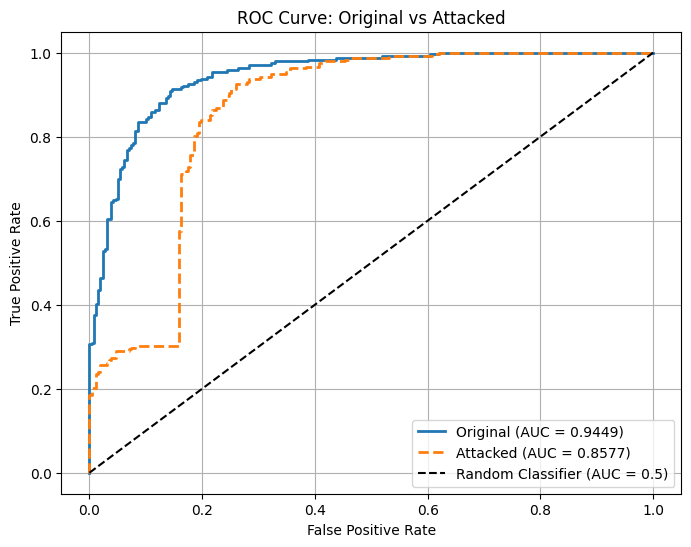

In [133]:
plot_roc_comparison(df_attacked=adversarial_df,
                    label_col='original_label',
                    original_score_col='score_before_attack',
                    attacked_score_col='score_after_attack')

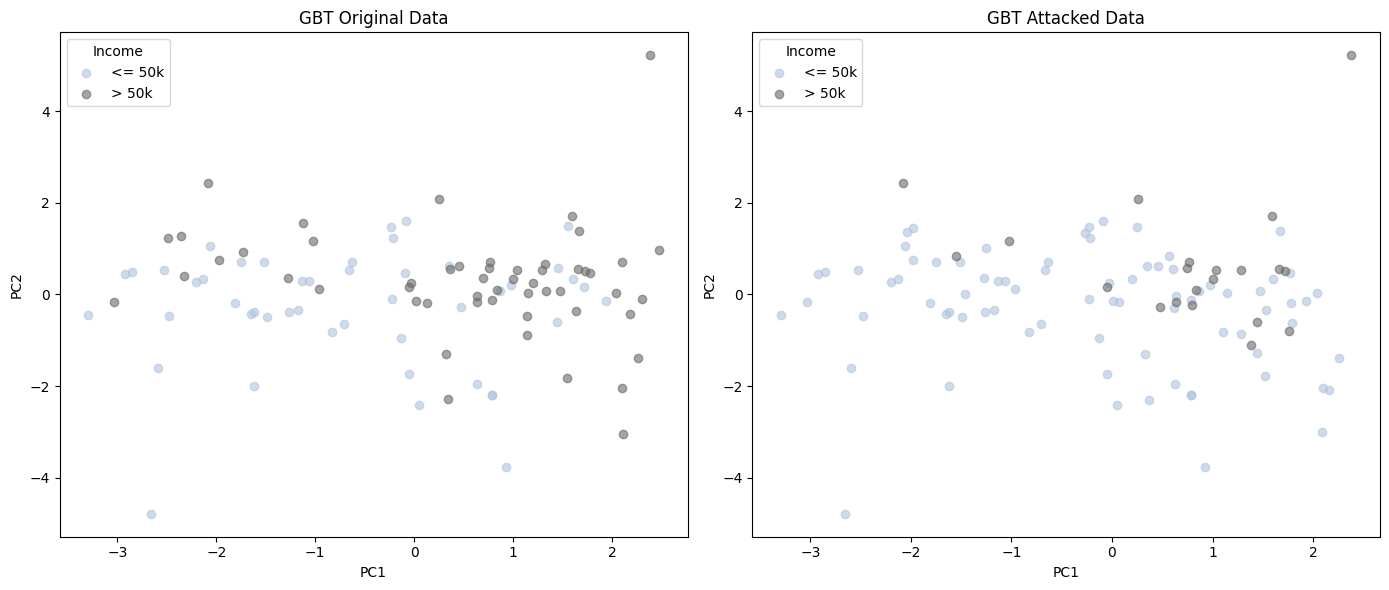

In [109]:
plot_pca_projection(
    df_original=df,
    df_attacked=adversarial_df,
    encoders=encoders,
    title_prefix='GBT '
)

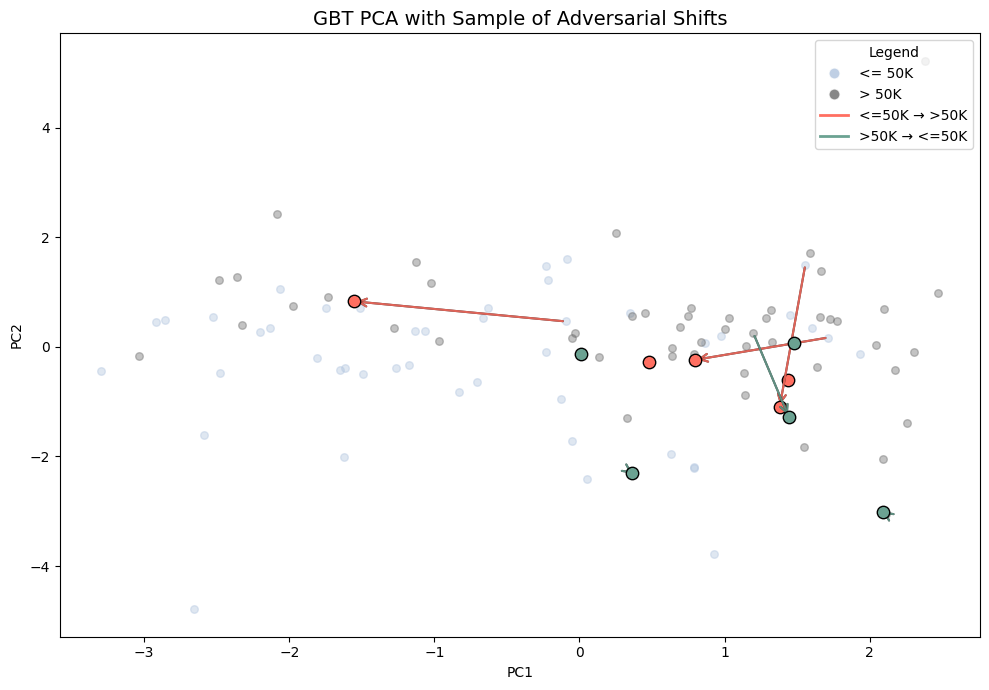

In [114]:
plot_adversarial_shift_arrows(
    df_original=df,
    df_attacked=adversarial_df,
    encoders=encoders,
    title_prefix='GBT '
)
